# The perceptron

Perceptrons, invented in the [1957]( https://en.wikipedia.org/wiki/Perceptron#History) by Frank Rosenblatt, are the simpliest form of feedforward networks. They are [linear classifiers](https://en.wikipedia.org/wiki/Linear_classifier) because they find a linear function to predict if a piece of data belongs to a determined class or not. A perceptron is basically formed by a layer of input units and a layer of output units. In the simpliest case the output layer is formed by just one unit:

![](perceptron.png)

<div>Table of contents</div>
<div id="toc"></div>

### Spreading  of activations
At each timestep of the simulation the first layer of units $\mathbf{x}=[x_0,\dots,x_n]$ is filled up with an input vector $\mathbf{p}_k=[p_{k0},\dots,p_{kn}]$. One unit of this layer, the bias, is not included in this update. instead it is permanently set to 1.
Each connection from a unit of the first layer to the output unit has a weight that is initially set to 0. The activation of the output unit is given by the weighted sum of the input units plus the weighted bias:
$$
y = \sum_{i=1}^{n+1} w_i x_i + w_0
$$
In python you can write:

```python
y = w[0]
for i in xrange(n): 
    y += w[i]*x[i]
```
Using linear algebra we can rewrite it in a shorter form as:
$$
\mathbf{y} = \mathbf{W}\mathbf{\tilde{x}}
$$
where $\mathbf{\tilde{x}} = (1, x_0, \dots, x_n)$ and $\mathbf{W}\mathbf{\tilde{x}}$ is is the [dot product](https://en.wikipedia.org/wiki/Dot_product#Algebraic_definition), a linear algebra operator that allows to calculate the  weighted sum at once.
In python it becomes:

```python
tx = hstack([1, x])
y = dot(w,tx)
```
*Using linear algebra in a neural network implementation is far simpler than writing loops, it is less error prone and also produces a much efficient code in terms of speed!!*

### Learning
Learning consists in updating the weights so that the weighted sum $y$ is more and more similar to a desired output $o_k$ when we give the input $p_k$ to the network.
In perceptrons learning can be done online, meaning that we can update the weights af
In practice learning is given at each timestep by:
$$
\Delta w_i = \eta (o_k - y)\tilde{x}_i
$$
or, in linear algebra notation:
$$
\Delta \mathbf{w} = \eta(o_k - y)\mathbf{\tilde{x}} 
$$
where $\eta$ is a value determining the rate of weight change per timestep (it is typically very little) and $o_k - y$ is the error in reproducing the desired value.
In python we write:
```python
w += eta*(o - y)*tx
```

### The decision boundary
The weights of the network can be viewed as the parameters of a linear equation. This equation defines a boundary in the space of all possible inputs. All points laying above the boundary belong to the class, all the others don't belong to it.
If the network has two inputs plus the bias the input space is a plane and the boundary is a row. In this case it is: $$
x_2 = -\frac{x_1 w_1 + w_0}{w_2}
$$


### The error

We can analyze if how much the network has learned by measuring the error. We compute the error at each timestep as the sum of the squares of the errors for each output unit:
$$
E_t = \sum_i \frac{1}{2}(o_i - y_i)^2
$$

If the network is learning the error diminuishes and it converges to a minimum. After a while the error cannot diminuish any more and the network reaches a steady state. 

### A simple simulation

In [57]:
%matplotlib inline
from pylab import *

Let us start by implementing a very simple network. Our network will only have two input units plus a bias unit. 
The network will learn to categorize few different input patterns in two classes:



#### Initializing data and parameters
We create input data with pseudo-random number generation

In [58]:
# each row of this array will contain a 2-element-wide 
# input pattern plus an integer defining to which category
# the pattern belongs
data = zeros([100,3])
np = 100

for t in xrange(np) :
    # the pattern is somewere nearby [0, 1] or [1, 0]
    pattern = eye(2)[t/(np/2)] +array([-1.2,.8]) + 0.15*randn(2)
    # first 50 belong to the first category
    category = 2*float(t/(np/2)) - 1
    # fill up data
    data[t,:] = hstack([pattern, category])

# each row of P is an input pattern
P = data[:,:2]

# each element of o is the desired output 
# relative to an input pattern
o = data[:,2]

Let's plot the input points, colors are the categories to which they belong:

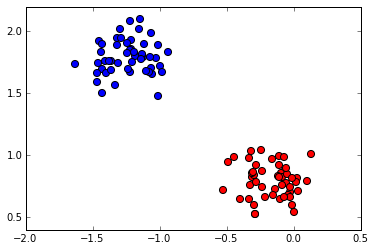

In [59]:
scatter(*P[:(np/2),:].T, s = 50,  c = 'r' )
scatter(*P[(np/2):,:].T, s = 50,  c = 'b' )
show()

Now some other initializations:

In [60]:
# constants
n = 2         # number of input elements
eta = 0.01    # learning rate
stime = 2500  # number of timesteps

#initialize weights
w = zeros(n+1)
# initialize the weight history storage
dw = zeros([n+1,stime])
# initialize the error history storage
E = zeros(stime)

#### Spreading of the network during training
Here starts the core part, iterating the timesteps:

In [61]:
for t in xrange(stime) :
    
    # reiterate the input pattern 
    # sequence through timesteps
    k = t%np
    
    # bias-plus-input vector
    tx = hstack([1, P[k]])
    
    # weighted sum - dot product
    y = dot(w, tx)
    
    # learning
    w += eta*(o[k] - y)*tx
       
    # store current weights
    dw[:,t] = w
    
    # current error
    E[t] = 0.5*(o[k] - y)**2
    
    # print weights every 100th timestep
    # (the '*' operator unpacks a container 
    # into its elements)    
    if t % 300 == 0 or t == stime-1 :
       # store current weights
          print "w = [ {:8.6f}   {:8.6f} {:8.6f} ] - " \
            "timestep = {:4.0f}" \
            .format( *hstack([w.round(6), t]) )        

w = [ -0.010000   0.001025 -0.006451 ] - timestep =    0
w = [ -0.465079   -0.649958 0.335045 ] - timestep =  300
w = [ -0.889498   -0.945962 0.384605 ] - timestep =  600
w = [ -1.148505   -1.108976 0.426822 ] - timestep =  900
w = [ -1.309740   -1.194314 0.464071 ] - timestep = 1200
w = [ -1.413017   -1.234486 0.497779 ] - timestep = 1500
w = [ -1.481780   -1.248590 0.528814 ] - timestep = 1800
w = [ -1.529840   -1.247834 0.557719 ] - timestep = 2100
w = [ -1.565342   -1.238788 0.584839 ] - timestep = 2400
w = [ -1.575951   -1.234580 0.593094 ] - timestep = 2499


#### Plotting
We can plot the history of the modifications of the decision boundary and the error curve:

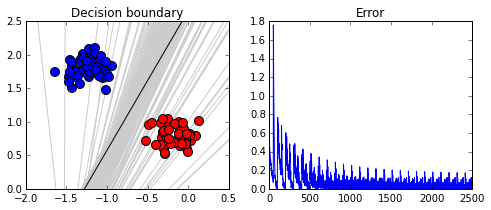

In [62]:
fig = figure(figsize=(8,3))

# first plot - scatter + decision boundary
subplot(121)
title('Decision boundary')
# we chose the x1 positions
x1 = array([-2.0,0.5])

# we can show how the decision boundary changed 
# as long as weights were updated
for t in xrange(stime) :
    # show evert 10th timestep
    if t%10 == 0:
        # evaluate x2 based on current weights
        x2 = -(dw[1,t]*x1 + dw[0,t])/dw[2,t]
        # plot
        plot(x1,x2, c=[.8,.8,.8], lw = 1, zorder = 1)

# evaluate x2 at the end of learning
x2 = -(w[1]*x1 + w[0])/w[2]
#plot
plot(x1,x2, c= 'k', lw = 1, zorder = 1)
fig.canvas.draw()

# show points
scatter(*P[:(np/2),:].T, s = 80,  c = 'r', zorder = 2 )
scatter(*P[(np/2):,:].T, s = 80,  c = 'b', zorder = 2 )       
xlim([-2.0,0.5])
ylim([0.0,2.5])

# second plot - error
subplot(122)
title('Error')
plot(E)

show()

### Recognising the MNIST digits

Let us implement a perceptron that categorize the MNIST images as numbers.

#### Initialize the dataset
First we initialize the dataset:

In [13]:
#### download the dataset 
# get the script from internet
! wget https://raw.githubusercontent.com/sorki/python-mnist/master/get_data.sh > /dev/null 2>&1  
# run it to dovnload all files in a local dir named 'data'
! bash get_data.sh >/dev/null 2>&1
# we do not need the script anymore, remove it
! rm get_data.sh* > /dev/null 2>&1

# initialize the dataset variables

%run utils

We now fill a array with all parameters. We will take the first 40 digits in the training set.

In [14]:
# set the number of patterns 
n_patterns = 40

# take 'n_patterns' rows
patterns = array(mndata.train_images)[:n_patterns]
# we rescale all patterns between 0 and 1
patterns = sign(patterns/255.0)
labels = array(mndata.train_labels)[:n_patterns]

Let us visualize them:

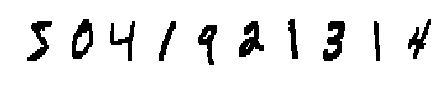

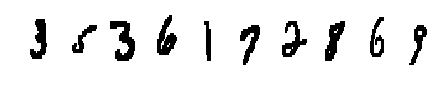

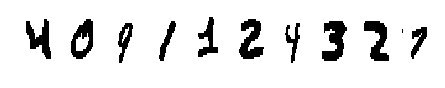

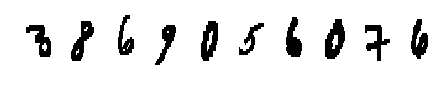

In [15]:
for i in xrange(n_patterns):
    if i%10 == 0:
        fig = figure(figsize = (30, 1))
    plot_img( to_mat(patterns[i]), 
        fig, (i%10)+1, windows = 40 )
    if i%10 == 9:
        show()

#### Iterating the timesteps

Now we implement the core part, defining what happens in each timestep.

> Note that now when we compute the activations we multiply a matrix $\mathbf{W}$ times a vector $\mathbf{tx}$. $\mathbf{W}\cdot\mathbf{tx}$ is the [matrix product](https://en.wikipedia.org/wiki/Matrix_multiplication#Matrix_product_.28two_matrices.29) of which the dot product is a [special case](https://en.wikipedia.org/wiki/Matrix_multiplication#Row_vector_and_column_vector).

In [16]:
# number of trials for learning
trials = 500

# learning rate
eta = 0.01

# number of output unit 
# (remember that the input is given by a 28*28 vector)
m = 10

# init weights
w = zeros([m, n+1])

# init input units
x = zeros(n)
# init output units
y = zeros(m)

# init desired output vector
y_target = zeros(m)

# we will store the input,  output and error history
input_store = zeros([n,trials])
output_store = zeros([m,trials])
E = zeros(trials)

# iterate
for t in xrange(trials) :
    
    # we present the input 
    # pattern sequence again and again
    k = t%n_patterns
    
    # aggregate inputs and the bias unit
    x = hstack([ 1, patterns[k] ])
    
    # only the unit representing the desired 
    # category is set to 1
    y_target *= 0
    y_target[labels[k]] = 1
    
    # the dot product becomes a matrix 
    # product with more than one output unit!!!!
    y = dot(w,x) 
    
    # learning - outer product
    w += eta*outer(y_target - y, x);
    
    input_store[:,t] = x[1:]
    output_store[:,t] = y
    E[t] = 0.5*sum((y_target - y)**2)
    

#### Plotting
We will create an animation showing the network learning to categorize the digits as numbers:

In [18]:
# The matplotlib object to do animations
from matplotlib import animation
# this grid allows to layout subplots in a more
# flexible way
import matplotlib.gridspec as gridspec

# initialize the figure for the animation    
def init_fig(timestep = 0) :    
    ''' 
    target_index :  (int)   the index of the target 
                            to plot
    returns      :          a tuple with the three 
                            plotting objects to render
    '''   
    # this is the input digit
    input_digit = input_store[:,timestep]
    output = output_store[:,timestep]
   
    # init the grid and the figure
    gs = gridspec.GridSpec(8, 24)
    fig = figure(figsize=(8, 3.5))        

    # plot 1 - plot the input digit
    ax1 = fig.add_subplot(gs[:4,:4])
    title("input")
    # create the imshow and save the handler
    im_input = ax1.imshow(to_mat(input_digit), 
                           interpolation = 'none', 
                           aspect = 'auto',
                           cmap = cm.binary) 
    axis('off')

    
    # plot 2 - plot the current state of the network
    ax2 = fig.add_subplot(gs[:4,6:14])
    title("output vector")
    # create the imshow and save the handler
    im_output = ax2.bar(arange(m),output) 

    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.set_xticks(arange(m)+.5)
    ax2.set_xticklabels(arange(m))
    ax2.set_yticks([])
    ylim([-.5,1])
 

    # plot 3 - plot the current history of error
    ax3 = fig.add_subplot(gs[:4,16:])
    title("Error")
    # create the line plot and save the handler
    im_E, = ax3.plot(E[timestep])
    # only bottom-left axes - no tics
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    xlim([0,trials])
    ylim([0,2])
    
    # return the handlers
    return fig,im_input,im_output,im_E

# Updates images at each frame of the animation
def update(data) :
    '''
    
    data    : (list of tuples)  each rows contains the
                                arguments of update for 
                                a frame
    returns :                   the handlers of the 
                                images                 
    '''
    # unpack data
    input_digit,output,E = data
    
    # update data of plot1,  2 and 3
    im_input.set_array(to_mat(input_digit))
    
    for rect, h in zip(im_output, output ) :
        rect.set_height(h)
    
    im_E.set_xdata(arange(len(E)))
    im_E.set_ydata(E)
    
    # return the handlers
    return im_input,im_output,im_E



In [19]:
# Our function to render videos inline 
# (see anim_to_html.py)
import anim_to_html as AH

# the first pattern
# initialize the figure

fig, im_input, im_output, im_E = init_fig()

# build the sequence of update arguments for pattern 0.
# each row of the list contains the activation vector at a 
# timestep and  a vector storing the energy story up to 
# that timestep. 
data = [ ( input_store[:,t],
           output_store[:,t], 
           E[:(t+1)] ) 
    for t in xrange(trials) ]

# create and render the animation
anim = animation.FuncAnimation(fig, update, data)
AH.display_animation(anim)

<br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br>
The next cell is just for styling

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../style/ipybn.css", "r").read()
    return HTML(styles)
css_styling()